## 3.5.3 Guided example and Challenge

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV


### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)

A = clf.score(X_test, y_test)

def accuracy_table(y_train, predict_train, y_test, predict_test):
    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

    print((
        'Training set accuracy:\n'
        'R-squared Score: {}\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}\n\n'
        'Test set accuracy:\n'
        'R-squared Score: {}\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(score_train, train_tI_errors, train_tII_errors, score_test, test_tI_errors, test_tII_errors))
accuracy_table(y_train, predict_train, y_test, predict_test)

Training set accuracy:
R-squared Score: 0.7774140752864157
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
R-squared Score: 0.7521472392638037
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

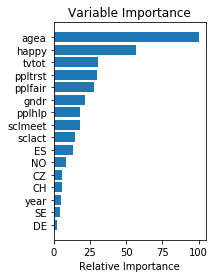

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [5]:
params = {'n_estimators': 20,
          'max_depth': 8,
          'subsample': 0.7,
          'min_weight_fraction_leaf': 0.2,
          'learning_rate': 0.08,
          'min_samples_split': 0.1,
          'loss': 'deviance'}

# Initialize and fit the model.
start = time.time()
clf_B = ensemble.GradientBoostingClassifier(**params)
clf_B.fit(X_train, y_train)
print ("Runtime: %0.2f seconds" % (time.time() - start))

predict_train_B = clf_B.predict(X_train)
predict_test_B = clf_B.predict(X_test)

score_train = clf_B.score(X_train, y_train)
score_test = clf_B.score(X_test, y_test)

B = clf_B.score(X_test, y_test)

accuracy_table(y_train, predict_train_B, y_test, predict_test_B)

Runtime: 0.13 seconds
Training set accuracy:
R-squared Score: 0.7296781232951446
Percent Type I errors: 0.04814511729405346
Percent Type II errors: 0.22217675941080198

Test set accuracy:
R-squared Score: 0.7300613496932515
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.20368098159509201


In [6]:
# feature engineering: top variable importance
X_feat = X[['agea', 'happy', 'tvtot', 'ppltrst', 'pplfair', 'gndr', 'pplhlp', 'sclmeet', 'sclact', 'ES']]

# Put 90% of the data in the training set.
X_feat_train = X_feat[:offset]

# And put 10% in the test set.
X_feat_test = X_feat[offset:]

# Initialize and fit the model.
start = time.time()
clf_2 = ensemble.GradientBoostingClassifier(**params)
clf_2.fit(X_feat_train, y_train)
print ("Runtime: %0.2f seconds" % (time.time() - start))

predict_train_C = clf_2.predict(X_feat_train)
predict_test_C = clf_2.predict(X_feat_test)

score_train = clf_2.score(X_feat_train, y_train)
score_test = clf_2.score(X_feat_test, y_test)

C = clf_2.score(X_feat_test, y_test)

accuracy_table(y_train, predict_train_C, y_test, predict_test_C)

Runtime: 0.11 seconds
Training set accuracy:
R-squared Score: 0.7296781232951446
Percent Type I errors: 0.04814511729405346
Percent Type II errors: 0.22217675941080198

Test set accuracy:
R-squared Score: 0.7300613496932515
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.20368098159509201


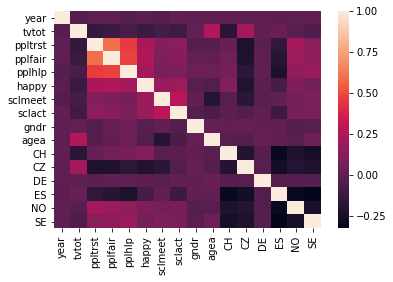

In [7]:
# feature engineering: PCA or correlation filtering
X_corr = X.corr()
sns.heatmap(X_corr);

In [8]:
# Combining ppltrst, ppltfair, pplhlp
X_feat['ppl'] = X_feat['ppltrst'] * X_feat['pplfair'] * X_feat['pplhlp']

# Put 90% of the data in the training set.
X_feat_train = X_feat[:offset]

# And put 10% in the test set.
X_feat_test = X_feat[offset:]

# Initialize and fit the model.
start = time.time()
clf_3 = ensemble.GradientBoostingClassifier(**params)
clf_3.fit(X_feat_train, y_train)
print ("Runtime: %0.2f seconds" % (time.time() - start))

predict_train_D = clf_3.predict(X_feat_train)
predict_test_D = clf_3.predict(X_feat_test)

score_train = clf_3.score(X_feat_train, y_train)
score_test = clf_3.score(X_feat_test, y_test)

D = clf_3.score(X_feat_test, y_test)

accuracy_table(y_train, predict_train_D, y_test, predict_test_D)

Runtime: 0.10 seconds
Training set accuracy:
R-squared Score: 0.7296781232951446
Percent Type I errors: 0.04814511729405346
Percent Type II errors: 0.22217675941080198

Test set accuracy:
R-squared Score: 0.7300613496932515
Percent Type I errors: 0.06625766871165645
Percent Type II errors: 0.20368098159509201


/home/mache/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_
)
display(pd.DataFrame(pca.components_,columns=X.columns))

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.93099424  0.02800132  0.01024528  0.00765152  0.0074001 ]


,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,CH,CZ,DE,ES,NO,SE
0,-0.000098,0.028574,-0.003645,0.001655,0.004770,-0.004118,-0.015370,-0.002961,0.000564,0.999440,-0.000331,-0.000621,0.000096,0.000261,-0.000485,0.001081
1,0.001650,0.145880,-0.585699,-0.555501,-0.516497,-0.216960,-0.081167,-0.054693,-0.001090,-0.005204,-0.011149,0.032046,0.000019,0.032548,-0.028000,-0.025463
2,0.010067,-0.957897,-0.045773,-0.071648,-0.216169,0.147868,0.035692,0.041293,-0.007224,0.029634,0.033189,-0.036952,0.000077,0.008141,-0.007566,0.003111
3,0.008975,-0.175907,0.216343,0.126221,0.007436,-0.863111,-0.375919,-0.138736,0.003328,-0.004161,-0.008454,0.022243,0.000224,-0.004131,-0.004596,-0.005285
4,-0.009107,-0.158264,-0.459850,-0.275480,0.819426,-0.071276,-0.089108,-0.037838,0.018230,-0.002396,0.018589,0.005911,0.000268,-0.024659,-0.011906,0.011796


In [10]:
# Put 90% of the data in the training set.
X_pca_train = X_pca[:offset]

# And put 10% in the test set.
X_pca_test = X_pca[offset:]

# Initialize and fit the model.
start = time.time()
clf_4 = ensemble.GradientBoostingClassifier(**params)
clf_4.fit(X_pca_train, y_train)
print ("Runtime: %0.2f seconds" % (time.time() - start))

predict_train_E = clf_4.predict(X_pca_train)
predict_test_E = clf_4.predict(X_pca_test)

score_train = clf_4.score(X_pca_train, y_train)
score_test = clf_4.score(X_pca_test, y_test)

E = clf_4.score(X_pca_test, y_test)

accuracy_table(y_train, predict_train_E, y_test, predict_test_E)

Runtime: 0.13 seconds
Training set accuracy:
R-squared Score: 0.7325422804146209
Percent Type I errors: 0.042007637752318604
Percent Type II errors: 0.22545008183306056

Test set accuracy:
R-squared Score: 0.7325153374233129
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.2049079754601227


### write-up

In [11]:
print('A = ', A)
print('B = ', B)
print('C = ', C)
print('D = ', D)
print('E = ', E)


A =  0.752147239264
B =  0.730061349693
C =  0.730061349693
D =  0.730061349693
E =  0.732515337423


After working with different variations, the best result was given with model C, using the top 10 features with variable importance.